## Data Analysis

### Data We Have

We have the following data:

 * `data/statements/contest_[en/ro].json` - the statements of the problems in the contest.
 * `data/solutions/solutions_[en/ro]_round_[1/2/3].json` - the solutions of the problems in the contest. We have 3 rounds for accounting for variations in the LLMs' answers.

TODO:
 * Take care of precision issues (maybe?).
 * Ro vs en statistics.
 * Probably relax the &lt;PYTHON CODE> tag, as models fail to insert it.
 * For MateInfoUB: Add redundant information?

### Loading the Data

In [1]:
import matplotlib.pyplot as plt
import duckdb
import pandas as pd
import numpy as np
import json
from collections import defaultdict
from IPython.core.magic import register_cell_magic

import internal_types
import compare_answers

def sql(*args):
    """
    Helper function to execute SQL queries.
    """
    return duckdb.sql(*args)


@register_cell_magic
def sql_magic(line, cell):
    return sql(cell)

In [2]:
def problem_index_to_difficulty(idx: int) -> str:
    """0-indexed idx to "easy", "medium" or "hard"."""
    assert 0 <= idx < 20
    if idx < 10:
        return "easy"
    elif idx < 16:
        return "medium"
    else:
        return "hard"

def problem_difficulty_to_points(difficulty: str) -> int:
    """Convert difficulty to points."""
    if difficulty == "easy":
        return 2
    elif difficulty == "medium":
        return 3
    elif difficulty == "hard":
        return 5
    else:
        assert False, f"Unknown difficulty {difficulty}"

def get_model_name(model: str) -> str:
    """Fix the model naming scheme"""
    if model == "gemini":
        return "Gemini 2.0 Flash"
    elif model == "gemini-2.5":
        return "Gemini 2.5 Experimental"
    elif model == "Llama-3.3-70B-Instruct-Turbo-Free":
        return "Llama 3.3 70B Instruct Turbo"
    elif model == "DeepSeek-R1":
        return "DeepSeek R1"
    elif model == "DeepSeek-V3":
        return "DeepSeek V3"
    elif model == "mistral":
        return "Mistral Large Latest"
    else:
        assert False, f"Unknown model {model}"

def read_json(file_glob: str, statement_file: str, language: str) -> duckdb.DuckDBPyRelation:
    """Read a JSON file and return a duckdb object."""
    statements_nested = duckdb.read_json(statement_file)
    statements = duckdb.sql(
        "SELECT name as edition, generate_subscripts(problems, 1) - 1 AS problem_index, unnest(problems, recursive := true) FROM statements_nested"
    )
    solutions = duckdb.read_json(file_glob)
    data_raw = duckdb.sql(
        "SELECT * FROM statements NATURAL JOIN solutions"
    )
    data = duckdb.sql(
        "SELECT *, answer = correct_answer AS correct FROM data_raw"
    ).df()
    # Add difficulty
    data["difficulty"] = data["problem_index"].apply(problem_index_to_difficulty)
    
    # Update the LLM column to be more readable
    data["llm"] = data["llm"].apply(get_model_name)

    # Add language
    data["lang"] = language

    # Convert back to duckdb.
    data = duckdb.from_df(data)
    return data

In [3]:
all_solutions = []
all_solutions_no_reasoning = []
all_solutions_no_multiple_choice = []

for lang, statement_path in internal_types.get_statement_files().items():
    solution_glob = internal_types.get_solutions_files_glob()[lang]
    solutions_no_reasoning_glob = internal_types.get_solution_files_no_reasoning_glob()[lang] 
    solutions_no_multiple_choice_glob = (
        internal_types.get_solution_files_no_multiple_choices_glob()[lang]
    )
    all_solutions.append(read_json(
        solution_glob,
        statement_path,
        lang
    ).df())
    all_solutions_no_reasoning.append(read_json(
        solutions_no_reasoning_glob,
        statement_path,
        lang
    ).df())
    all_solutions_no_multiple_choice.append(read_json(
        solutions_no_multiple_choice_glob,
        statement_path,
        lang
    ).df())

# Combine all solutions
solutions = pd.concat(all_solutions, ignore_index=True)
solutions_no_reasoning = pd.concat(all_solutions_no_reasoning, ignore_index=True)
solutions_no_multiple_choice = pd.concat(all_solutions_no_multiple_choice, ignore_index=True)

# Convert back to duckdb
solutions = duckdb.from_df(solutions)
solutions_no_reasoning = duckdb.from_df(solutions_no_reasoning)
solutions_no_multiple_choice = duckdb.from_df(solutions_no_multiple_choice)

# We need to fix the solutions with no multiple choices, as the answers might be wrong.
fixed = solutions_no_multiple_choice.df()
fixed["correct"] = fixed.apply(
    lambda row: compare_answers.compare_answers(row["correct_answer"], row["answer"]), axis=1
)
solutions_no_multiple_choice = duckdb.from_df(fixed)

MODELS = [i[0] for i in duckdb.sql("SELECT DISTINCT llm FROM solutions").fetchall()]
LANGS = [i[0] for i in duckdb.sql("SELECT DISTINCT lang FROM solutions").fetchall()]
NR_PROBLEMS = 20
NR_CONTESTS = 4

### Computing Models vs Students

DeepSeek R1 in Ediția 2021: total points - 9.00 / ranking - 158/157 / percentile - 100.00%
DeepSeek R1 in Ediția 2022: total points - 24.67 / ranking - 178/177 / percentile - 100.00%
DeepSeek R1 in Ediția 2023: total points - 26.33 / ranking - 156/195 / percentile - 79.49%
DeepSeek R1 in Ediția 2024: total points - 20.33 / ranking - 192/191 / percentile - 100.00%
Mistral Large Latest in Ediția 2021: total points - 21.00 / ranking - 158/157 / percentile - 100.00%
Mistral Large Latest in Ediția 2022: total points - 28.33 / ranking - 164/177 / percentile - 92.09%
Mistral Large Latest in Ediția 2023: total points - 25.33 / ranking - 168/195 / percentile - 85.64%
Mistral Large Latest in Ediția 2024: total points - 32.33 / ranking - 20/191 / percentile - 9.95%
DeepSeek V3 in Ediția 2021: total points - 30.00 / ranking - 61/157 / percentile - 38.22%
DeepSeek V3 in Ediția 2022: total points - 28.00 / ranking - 164/177 / percentile - 92.09%
DeepSeek V3 in Ediția 2023: total points - 32.33 / ran

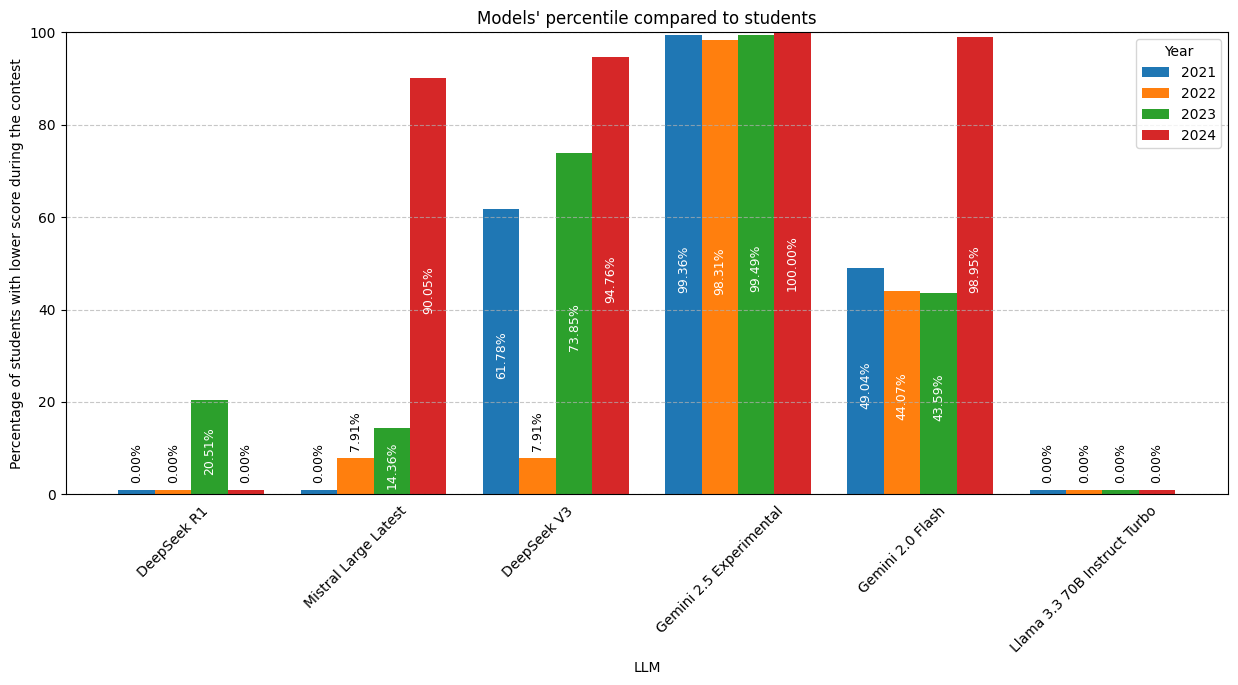

In [27]:
student_points = {
    "Ediția 2021": json.loads(
        open(
            internal_types.DATA_DIR / ".." / "other" / "2021_qualified_points.json"
        ).read()
    ),
    "Ediția 2022": json.loads(
        open(
            internal_types.DATA_DIR / ".." / "other" / "2022_qualified_points.json"
        ).read()
    ),
    "Ediția 2023": json.loads(
        open(
            internal_types.DATA_DIR / ".." / "other" / "2023_qualified_points.json"
        ).read()
    ),
    "Ediția 2024": json.loads(
        open(
            internal_types.DATA_DIR / ".." / "other" / "2024_qualified_points.json"
        ).read()
    ),
}

percentile_data = {
    model: dict()
    for model in MODELS
}

for model in MODELS:
    for edition in student_points.keys():
        # get the model's results.
        total_points = 0
        total_problems = 0
        for difficulty, is_correct in duckdb.sql(
            f"""
            SELECT difficulty, correct
            FROM solutions
            WHERE llm = '{model}' AND edition = '{edition}' and lang = 'ro'
            """
        ).fetchall():
            if is_correct:
                total_points += problem_difficulty_to_points(difficulty)
            total_problems += 1

        # We have 3 trials.
        if total_problems != 60:
            print(f"Warning: {model} did not solve all problems in {edition}.")
            continue

        # The average nr of points obtained by the model.
        total_points /= 3

        # See the ranking of the model compared to the students.
        nr_students = len(student_points[edition])
        nr_students_better = len([
            i for i in student_points[edition] if i > total_points
        ])
        ranking = 1 + nr_students_better

        # The ranking percentile.
        percentile = 100 * (nr_students_better / nr_students)

        print(f"{model} in {edition}: total points - {total_points:.2f} / ranking - {ranking}/{nr_students} / percentile - {percentile:.2f}%")
        # print(f"  - Total points: {total_points:.2f}")
        # print(f"  - Ranking: {ranking}/{nr_students} ({percentile:.2f}%)")
        # print(f"  - Percentile: Top {percentile:.2f}% of the students")

        percentile_data[model][edition] = 100 - percentile

# Plot the data
plt.figure(figsize=(15, 6))
bar_width = 0.2
index = np.arange(len(MODELS))

for i, edition in enumerate(student_points.keys()):
    percentile = [percentile_data[model][edition] for model in MODELS]
    bars = plt.bar(
        index + (i + 0.5) * bar_width,
        [max(i, 1) for i in percentile],
        bar_width,
        label=f"{edition.split()[1]}",
    )

    # Add values on top of the bars
    for bar, percentile in zip(bars, percentile):
        plt.text(
            bar.get_x() + bar_width / 2,
            (bar.get_height() + 1.5 if percentile < 10 else bar.get_height() / 2 - 6),
            f"{percentile:.2f}%",
            ha="center",
            va="bottom",
            fontsize=9,
            color=(
                "black" if percentile < 10 else "white"
            ),
            rotation=90
        )

plt.xlabel("LLM")
plt.ylabel("Percentage of students with lower score during the contest")
plt.title("Models' percentile compared to students")
plt.xticks(index + bar_width * 1.5, MODELS, rotation=45)
plt.tick_params(axis="x", which="both", bottom=False)
plt.ylim(0, 100)
plt.legend(title="Year")
plt.grid(axis="y", linestyle="--", alpha=0.7)
# plt.tight_layout()
plt.show()

### Computing the average accuracy by LLM

We are computing the average accuracy by LLM for each problem category (easy / medium / hard).

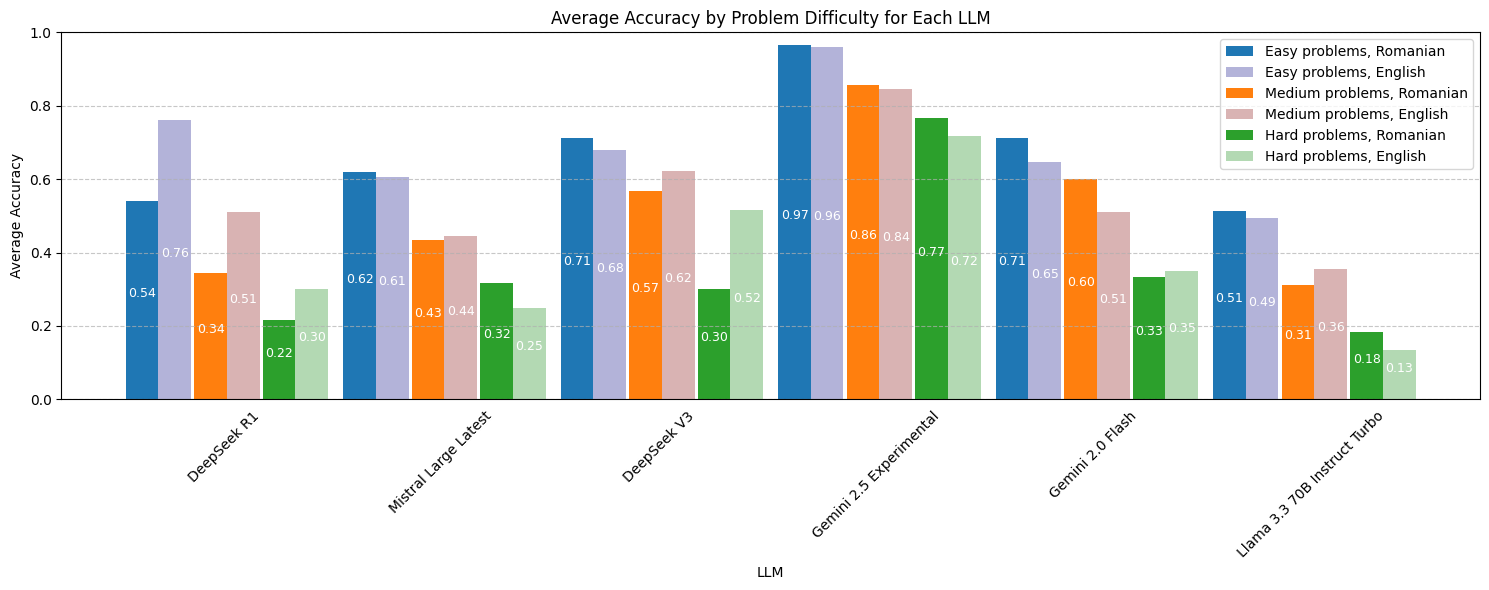

In [5]:
# Create a single plot with combined data for different languages
plt.figure(figsize=(15, 6))
bar_width = 0.15  # Reduced bar width for less spacing between LLMs
index = np.arange(len(MODELS))

# Define colors for each difficulty level using the standard matplotlib palette and lighter versions
colors = {
    "easy": {"lang1": "C0", "lang2": (0.7, 0.7, 0.85)},
    "medium": {"lang1": "C1", "lang2": (0.85, 0.7, 0.7)},
    "hard": {"lang1": "C2", "lang2": (0.7, 0.85, 0.7)},
}

# Store data for both languages
average_plot_data = {lang: {} for lang in LANGS}

for lang in LANGS:
    # Extract data from DuckDB
    df = duckdb.sql(
        f"""
        SELECT edition, problem_index, llm, SUM(correct) as correct, AVG(CAST(correct as float)) as accuracy
        FROM solutions
        WHERE lang = '{lang}'
        GROUP BY edition, problem_index, llm
    """
    ).df()

    plot_data = {model: {"easy": [], "medium": [], "hard": []} for model in MODELS}
    for _, row in df.iterrows():
        plot_data[row["llm"]][problem_index_to_difficulty(row["problem_index"])].append(
            row["accuracy"]
        )

    # Calculate average accuracy for each difficulty level
    average_plot_data[lang] = {
        model: {
            difficulty: np.mean(accuracies) for difficulty, accuracies in data.items()
        }
        for model, data in plot_data.items()
    }

# Plot the data
lang_to_name = {
    "ro": "Romanian",
    "en": "English",
}
for i, difficulty in enumerate(["easy", "medium", "hard"]):
    for j, lang in enumerate(LANGS):
        accuracies = [average_plot_data[lang][model][difficulty] for model in MODELS]
        bars = plt.bar(
            index + (2.1 * i + j) * bar_width,
            accuracies,
            bar_width,
            label=f"{difficulty.capitalize()} problems, {lang_to_name[lang]}",
            color=colors[difficulty][f"lang{j+1}"],
        )

        # Add values on top of the bars
        for bar, accuracy in zip(bars, accuracies):
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() / 2,
                f"{accuracy:.2f}",
                ha="center",
                va="bottom",
                fontsize=9,
                color="white",
            )

plt.xlabel("LLM")
plt.ylabel("Average Accuracy")
plt.title("Average Accuracy by Problem Difficulty for Each LLM")
plt.xticks(index + 2.5 * bar_width, MODELS, rotation=45)  # Adjusted xticks position
plt.tick_params(axis="x", which="both", bottom=False)  # Remove ticks on the x-axis
plt.ylim(0, 1)
plt.legend(
    # title="Difficulty", loc="center left", bbox_to_anchor=(1, 0.5)
)  # Move legend outside the plot
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

### Computing success rate when reasoning is asked vs not asked

We compute the average accuracy of the models when we ask the model for reasoning steps vs when we don't.

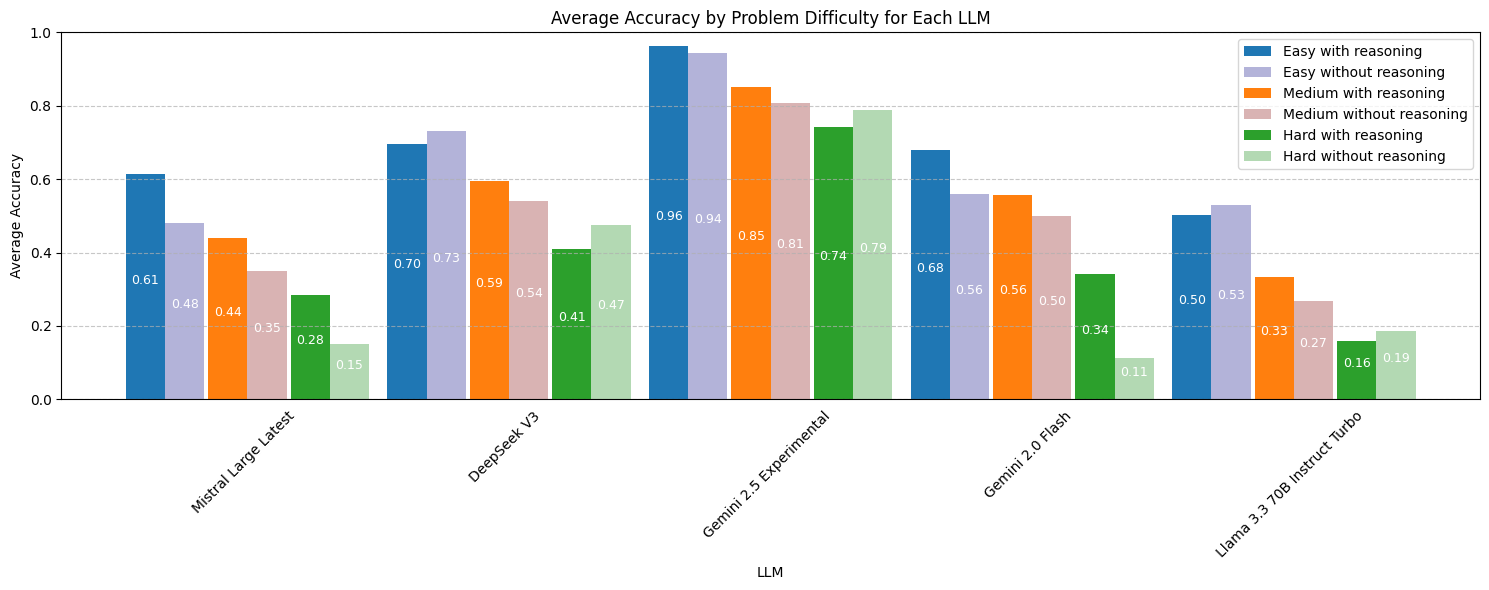

In [6]:
# Create a single plot with combined data for solutions and solutions_no_reasoning
plt.figure(figsize=(15, 6))
bar_width = 0.15  # Reduced bar width for less spacing between LLMs
FILTERED_MODELS = [i for i in MODELS if i != "DeepSeek R1"]
index = np.arange(len(FILTERED_MODELS))

# Define colors for each difficulty level using the standard matplotlib palette and lighter versions
colors = {
    "easy": {"with_reasoning": "C0", "without_reasoning": (0.7, 0.7, 0.85)},
    "medium": {"with_reasoning": "C1", "without_reasoning": (0.85, 0.7, 0.7)},
    "hard": {"with_reasoning": "C2", "without_reasoning": (0.7, 0.85, 0.7)},
}

# Store data for both solutions and solutions_no_reasoning
average_plot_data_with_reasoning = {}
average_plot_data_without_reasoning = {}

for sol_file, use_reasoning in zip(
    ["solutions", "solutions_no_reasoning"], [True, False]
):
    # Extract data from DuckDB
    df = duckdb.sql(
        f"""
        SELECT edition, problem_index, llm, SUM(correct) as correct, AVG(CAST(correct as float)) as accuracy
        FROM {sol_file}
        GROUP BY edition, problem_index, llm
    """
    ).df()

    plot_data = {model: {"easy": [], "medium": [], "hard": []} for model in MODELS}
    for _, row in df.iterrows():
        plot_data[row["llm"]][problem_index_to_difficulty(row["problem_index"])].append(
            row["accuracy"]
        )

    # Calculate average accuracy for each difficulty level
    average_plot_data = {
        model: {
            difficulty: np.mean(accuracies) for difficulty, accuracies in data.items()
        }
        for model, data in plot_data.items()
    }

    if use_reasoning:
        average_plot_data_with_reasoning = average_plot_data
    else:
        average_plot_data_without_reasoning = average_plot_data

# Plot the data
for i, difficulty in enumerate(["easy", "medium", "hard"]):
    accuracies_with_reasoning = [
        average_plot_data_with_reasoning[model][difficulty] for model in FILTERED_MODELS
    ]
    accuracies_without_reasoning = [
        average_plot_data_without_reasoning[model][difficulty]
        for model in FILTERED_MODELS
    ]

    bars_with_reasoning = plt.bar(
        index + 2 * i * (bar_width * 1.05),
        accuracies_with_reasoning,
        bar_width,
        label=f"{difficulty.capitalize()} with reasoning",
        color=colors[difficulty]["with_reasoning"],
    )

    bars_without_reasoning = plt.bar(
        index + 2 * i * (bar_width * 1.05) + bar_width,
        accuracies_without_reasoning,
        bar_width,
        label=f"{difficulty.capitalize()} without reasoning",
        color=colors[difficulty]["without_reasoning"],
    )

    # Add values on top of the bars
    for bar, accuracy in zip(bars_with_reasoning, accuracies_with_reasoning):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() / 2,
            f"{accuracy:.2f}",
            ha="center",
            va="bottom",
            fontsize=9,
            color="white",
        )

    for bar, accuracy in zip(bars_without_reasoning, accuracies_without_reasoning):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() / 2,
            f"{accuracy:.2f}",
            ha="center",
            va="bottom",
            fontsize=9,
            color="white",
        )

plt.xlabel("LLM")
plt.ylabel("Average Accuracy")
plt.title("Average Accuracy by Problem Difficulty for Each LLM")
plt.xticks(
    index + 2.5 * bar_width, FILTERED_MODELS, rotation=45
)  # Adjusted xticks position
plt.tick_params(axis="x", which="both", bottom=False)  # Remove ticks on the x-axis
plt.ylim(0, 1)
plt.legend(
    # title="Difficulty", # loc="center left", bbox_to_anchor=(1, 0.5)
)  # Move legend outside the plot
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

### Computing The number of Python solutions vs direct answers

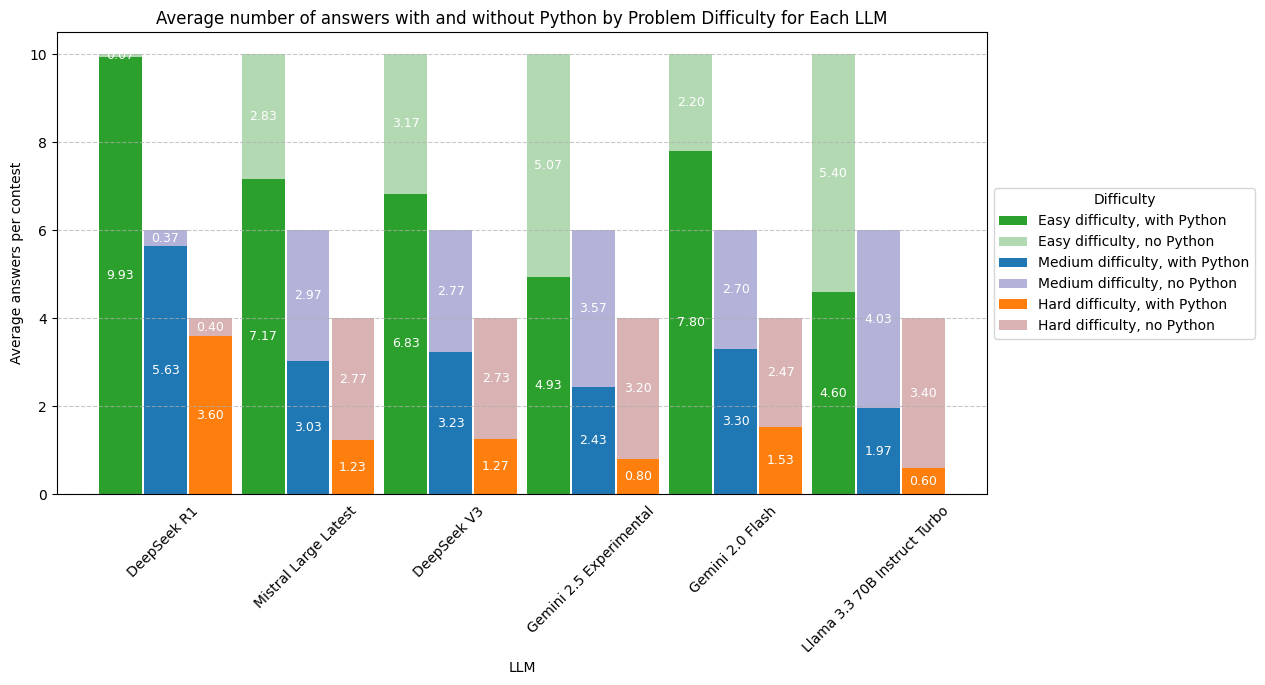

In [7]:
# Create a single plot with combined data for use_python and don't use python
plt.figure(figsize=(12, 6))
bar_width = 0.3  # Reduced bar width for less spacing between LLMs
index = np.arange(len(MODELS))

# Store data for both use_python and don't use python
total_plot_data_with_python = {}
total_plot_data_without_python = {}

# Define colors for each difficulty level using the standard matplotlib palette and slightly darker versions
colors = {
    "easy": {"without_python": (0.7, 0.85, 0.7), "with_python": "C2"},
    "medium": {"without_python": (0.7, 0.7, 0.85), "with_python": "C0"},
    "hard": {"without_python": (0.85, 0.7, 0.7), "with_python": "C1"},
}

for use_python in [True, False]:
    # Extract data from DuckDB
    df = duckdb.sql(
        f"""
        SELECT problem_index, llm, SUM(correct) / 30 as correct, COUNT(*) / 30 as total
        FROM solutions
        WHERE python_code is {"" if use_python else "not"} null
        GROUP BY problem_index, llm
    """
    ).df()

    plot_data = {model: {"easy": [], "medium": [], "hard": []} for model in MODELS}
    for _, row in df.iterrows():
        plot_data[row["llm"]][problem_index_to_difficulty(row["problem_index"])].append(
            row["total"]
        )

    # Calculate total for each difficulty level
    total_plot_data = {
        model: {difficulty: np.sum(total) for difficulty, total in data.items()}
        for model, data in plot_data.items()
    }

    if use_python:
        total_plot_data_with_python = total_plot_data
    else:
        total_plot_data_without_python = total_plot_data

# Plot the data
for i, difficulty in enumerate(["easy", "medium", "hard"]):
    totals_with_python = [
        total_plot_data_with_python[model][difficulty] for model in MODELS
    ]
    totals_without_python = [
        total_plot_data_without_python[model][difficulty] for model in MODELS
    ]

    bars_with_python = plt.bar(
        index + i * bar_width * 1.05,
        totals_with_python,
        bar_width,
        label=f"{difficulty.capitalize()} difficulty, with Python",
        color=colors[difficulty]["with_python"],
    )

    bars_without_python = plt.bar(
        index + i * bar_width * 1.05,
        totals_without_python,
        bar_width,
        bottom=totals_with_python,
        label=f"{difficulty.capitalize()} difficulty, no Python",
        color=colors[difficulty]["without_python"],
    )

    # Add values on top of the bars
    for bar_with, bar_without, total_with, total_without in zip(
        bars_with_python, bars_without_python, totals_with_python, totals_without_python
    ):
        plt.text(
            bar_with.get_x() + bar_with.get_width() / 2,
            bar_with.get_height() / 2,
            f"{total_with:.2f}",
            ha="center",
            va="center",
            fontsize=9,
            color="white",
        )
        plt.text(
            bar_without.get_x() + bar_without.get_width() / 2,
            bar_with.get_height() + bar_without.get_height() / 2,
            f"{total_without:.2f}",
            ha="center",
            va="center",
            fontsize=9,
            color="white",
        )

plt.xlabel("LLM")
plt.ylabel("Average answers per contest")
plt.title(
    "Average number of answers with and without Python by Problem Difficulty for Each LLM"
)
plt.xticks(index + 1 * bar_width, MODELS, rotation=45)  # Adjusted xticks position
plt.tick_params(axis="x", which="both", bottom=False)  # Remove ticks on the x-axis
plt.legend(title="Difficulty")
plt.grid(axis="y", linestyle="--", alpha=0.7)
# plt.tight_layout()
plt.legend(
    title="Difficulty", loc="center left", bbox_to_anchor=(1, 0.5)
)  # Move legend outside the plot
plt.show()

### Computing Success rate when using Python

Writing python code is challenging, so seeing the success rate of the LLMs when using Python is interesting.

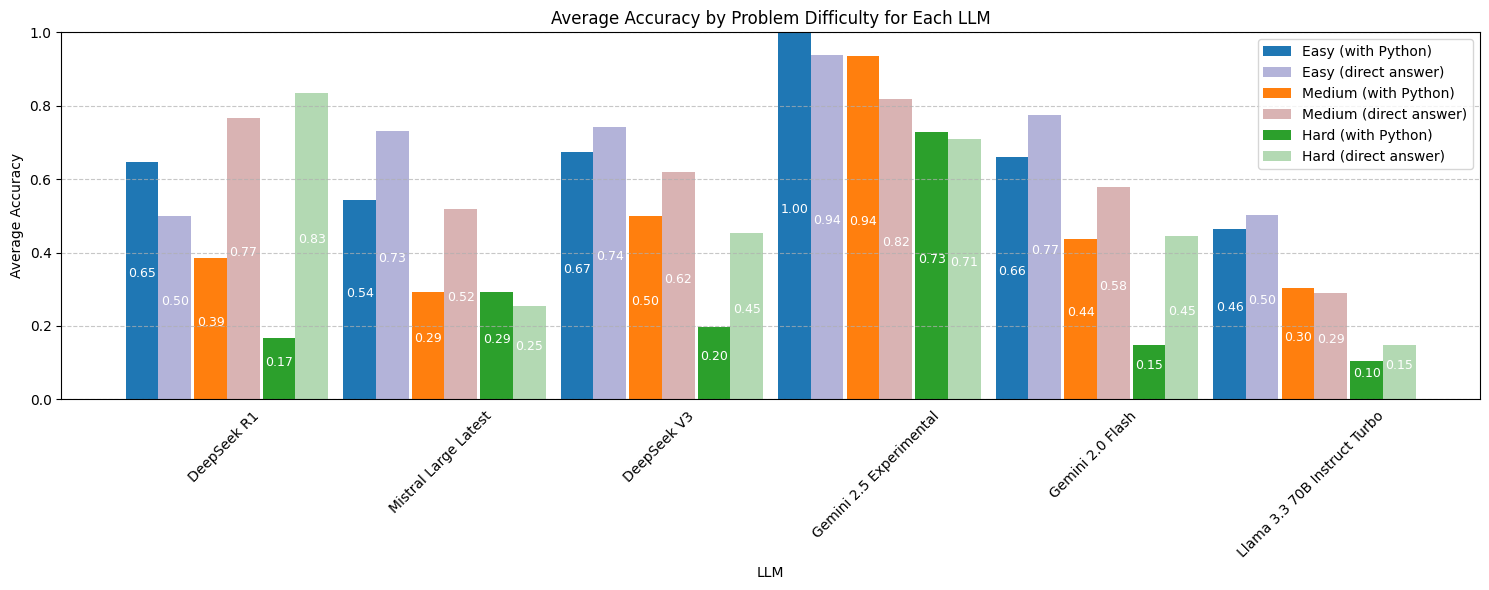

In [8]:
# Create a single plot with combined data for with Python and without Python
plt.figure(figsize=(15, 6))
bar_width = 0.15  # Reduced bar width for less spacing between LLMs
index = np.arange(len(MODELS))

# Define colors for each difficulty level using the standard matplotlib palette and lighter versions
colors = {
    "easy": {"with_python": "C0", "without_python": (0.7, 0.7, 0.85)},
    "medium": {"with_python": "C1", "without_python": (0.85, 0.7, 0.7)},
    "hard": {"with_python": "C2", "without_python": (0.7, 0.85, 0.7)},
}

# Store data for both with Python and without Python
average_plot_data = {"with_python": {}, "without_python": {}}

for use_python, key in zip([True, False], ["with_python", "without_python"]):
    # Extract data from DuckDB
    df = duckdb.sql(
        f"""
        SELECT edition, problem_index, llm, SUM(correct) as correct, AVG(CAST(correct as float)) as accuracy
        FROM solutions
        WHERE python_code is {"" if use_python else "not"} null
        GROUP BY edition, problem_index, llm
    """
    ).df()

    plot_data = {model: {"easy": [], "medium": [], "hard": []} for model in MODELS}
    for _, row in df.iterrows():
        plot_data[row["llm"]][problem_index_to_difficulty(row["problem_index"])].append(
            row["accuracy"]
        )

    # Calculate average accuracy for each difficulty level
    average_plot_data[key] = {
        model: {
            difficulty: np.mean(accuracies) for difficulty, accuracies in data.items()
        }
        for model, data in plot_data.items()
    }

# Plot the data
for i, difficulty in enumerate(["easy", "medium", "hard"]):
    for j, key in enumerate(["with_python", "without_python"]):
        accuracies = [average_plot_data[key][model][difficulty] for model in MODELS]
        bars = plt.bar(
            index + (2.1 * i + j) * bar_width,
            accuracies,
            bar_width,
            label=(
                f"{difficulty.capitalize()} ({'with Python' if key == 'with_python' else 'direct answer'})"
            ),
            color=colors[difficulty][key],
        )

        # Add values on top of the bars
        for bar, accuracy in zip(bars, accuracies):
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() / 2,
                f"{accuracy:.2f}",
                ha="center",
                va="bottom",
                fontsize=9,
                color="white",
            )

plt.xlabel("LLM")
plt.ylabel("Average Accuracy")
plt.title("Average Accuracy by Problem Difficulty for Each LLM")
plt.xticks(index + 2.5 * bar_width, MODELS, rotation=45)  # Adjusted xticks position
plt.tick_params(axis="x", which="both", bottom=False)  # Remove ticks on the x-axis
plt.ylim(0, 1)
plt.legend(
    # title="Difficulty", loc="center left", bbox_to_anchor=(1, 0.5)
)  # Move legend outside the plot
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

### Computing success rate when multiple choice answers are not provided

/home/theodor/.venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/theodor/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


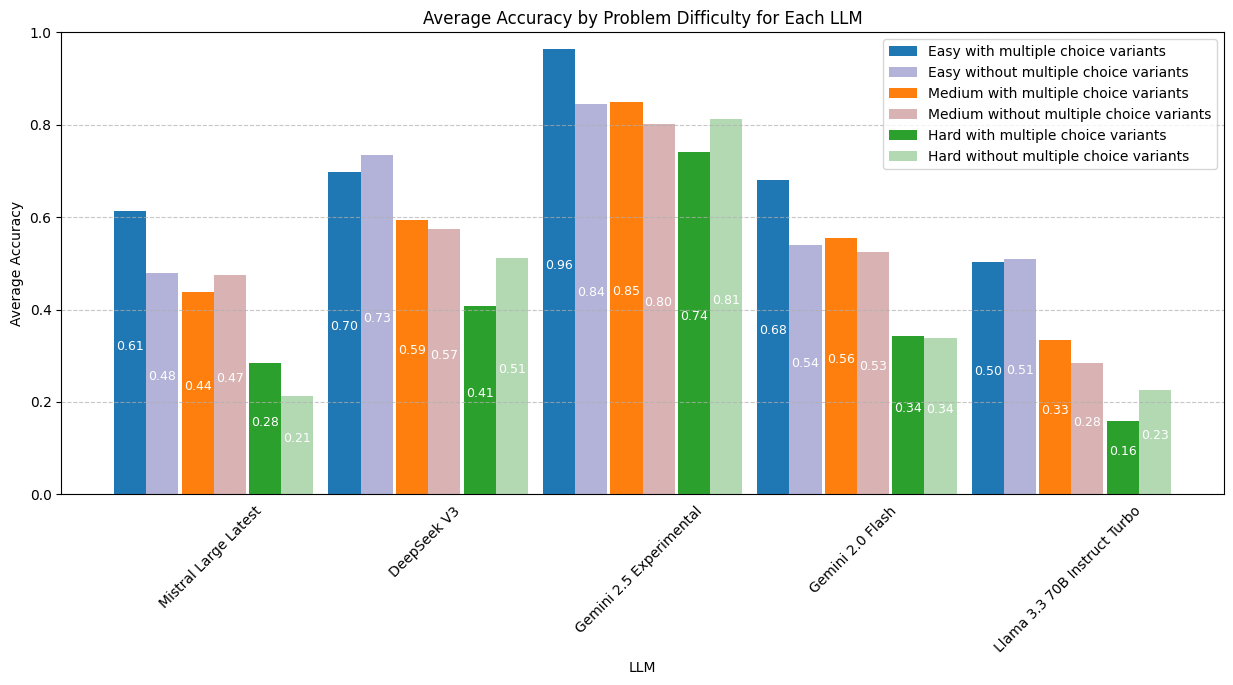

In [9]:
# Create a single plot with combined data for solutions and solutions_no_reasoning
plt.figure(figsize=(15, 6))
bar_width = 0.15  # Reduced bar width for less spacing between LLMs
FILTERED_MODELS = [i for i in MODELS if i != "DeepSeek R1"]
index = np.arange(len(FILTERED_MODELS))

# Define colors for each difficulty level using the standard matplotlib palette and lighter versions
colors = {
    "easy": {"with_multiple_choice": "C0", "without_multiple_choice": (0.7, 0.7, 0.85)},
    "medium": {"with_multiple_choice": "C1", "without_multiple_choice": (0.85, 0.7, 0.7)},
    "hard": {"with_multiple_choice": "C2", "without_multiple_choice": (0.7, 0.85, 0.7)},
}

# Store data for both solutions and solutions_no_reasoning
average_plot_data_with_multiple_choice = {}
average_plot_data_without_multiple_choice = {}

for sol_file, multiple_choice_provided in zip(
    ["solutions", "solutions_no_multiple_choice"], [True, False]
):
    # Extract data from DuckDB
    df = duckdb.sql(
        f"""
        SELECT edition, problem_index, llm, SUM(correct) as correct, AVG(CAST(correct as float)) as accuracy
        FROM {sol_file}
        GROUP BY edition, problem_index, llm
    """
    ).df()

    plot_data = {model: {"easy": [], "medium": [], "hard": []} for model in MODELS}
    for _, row in df.iterrows():
        plot_data[row["llm"]][problem_index_to_difficulty(row["problem_index"])].append(
            row["accuracy"]
        )

    # Calculate average accuracy for each difficulty level
    average_plot_data = {
        model: {
            difficulty: np.mean(accuracies) for difficulty, accuracies in data.items()
        }
        for model, data in plot_data.items()
    }

    if multiple_choice_provided:
        average_plot_data_with_multiple_choice = average_plot_data
    else:
        average_plot_data_without_multiple_choice = average_plot_data

# Plot the data
for i, difficulty in enumerate(["easy", "medium", "hard"]):
    accuracies_with_multiple_choice = [
        average_plot_data_with_multiple_choice[model][difficulty] for model in FILTERED_MODELS
    ]
    accuracies_without_multiple_choice = [
        average_plot_data_without_multiple_choice[model][difficulty]
        for model in FILTERED_MODELS
    ]

    bars_with_multiple_choice = plt.bar(
        index + 2 * i * (bar_width * 1.05),
        accuracies_with_multiple_choice,
        bar_width,
        label=f"{difficulty.capitalize()} with multiple choice variants",
        color=colors[difficulty]["with_multiple_choice"],
    )

    bars_without_multiple_choice = plt.bar(
        index + 2 * i * (bar_width * 1.05) + bar_width,
        accuracies_without_multiple_choice,
        bar_width,
        label=f"{difficulty.capitalize()} without multiple choice variants",
        color=colors[difficulty]["without_multiple_choice"],
    )

    # Add values on top of the bars
    for bar, accuracy in zip(bars_with_multiple_choice, accuracies_with_multiple_choice):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() / 2,
            f"{accuracy:.2f}",
            ha="center",
            va="bottom",
            fontsize=9,
            color="white",
        )

    for bar, accuracy in zip(bars_without_multiple_choice, accuracies_without_multiple_choice):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() / 2,
            f"{accuracy:.2f}",
            ha="center",
            va="bottom",
            fontsize=9,
            color="white",
        )

plt.xlabel("LLM")
plt.ylabel("Average Accuracy")
plt.title("Average Accuracy by Problem Difficulty for Each LLM")
plt.xticks(
    index + 2.5 * bar_width, FILTERED_MODELS, rotation=45
)  # Adjusted xticks position
plt.tick_params(axis="x", which="both", bottom=False)  # Remove ticks on the x-axis
plt.ylim(0, 1)
plt.legend(
    # title="Difficulty", # loc="center left", bbox_to_anchor=(1, 0.5)
)  # Move legend outside the plot
plt.grid(axis="y", linestyle="--", alpha=0.7)
# plt.tight_layout()
plt.show()